# Model fitting

## Preprocessing

* Import the saved tutor data from the tutor_main table in the postgreSQL database.
* Import the corresponding tutor subjects from the tutor_subjects table in the postgreSQL database.
* Join these two tables on tutor_id and combine all subjects into a single string for each tutor.
* Log-transform the target variable (hourly rates) as this removes outliers and results in better model performance.


## Feature engineering

Create the following new features:

1. qual_encoded: a weighted score based on the tutor's qualifications.
2. all_ed: all the institutions attended by that tutor, combined into a single string.
3. ivy_1e, ivy_2e, ivy_3e: Boolean fields which state if the 1st, 2nd and 3rd institutions are belong to the Ivy League, respectively.
4. state_1e, state_2e, state_3e: Boolean fields which state if the 1st, 2nd and 3rd institutions are state insititutions, respectively.
5. experience: Number of years of experience, extracted using a search for digits in the tutor bio section.
6. exptext: Number of years of experience, extracted using a search for numbers in text format in the tutor bio section.
7. exp_tot: The sum of experience and exptext.
8. ed_0 and ed_1: the first 2 principal components of the TFIDF-vectorized all_ed column.
9. sub_0 - sub_4: the first 5 principal components of the TFIDF-vectorized subjects column.

## Model details

* XGBoost regressor was found to give the best performance both in terms of mean absolute error and R squared metrics, ahead of alternatives such as linear regression, lasso, and ridge regression.
* Categorical variables were encoded using the catboost encoder, a form of target encoding which avoids data leakage (http://contrib.scikit-learn.org/category_encoders/catboost.html).
* A simple grid search was used to determine optimal hyperparameters (however this was by no means an exhaustive search, and marginal improvement could probably be achieved by other methods, such as Bayesian optimization).

Note: feature selection showed that no additional variance was explained by including features derived from TFIDF-encoding the bio section, so they were not included in the final model.

In [40]:
import feat_eng_funcs as fe
import sql_funcs as sf
import pandas as pd
import numpy as np
import pickle
import seaborn as sb
from matplotlib import pyplot as plt

import category_encoders as ce
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

## Load data and perform initial feature engineering

In [2]:
con = sf.open_sql_con()

sql_query = """
SELECT * FROM tutor_main
"""
tutor_data = pd.read_sql_query(sql_query,con)

tutor_data = tutor_data.drop_duplicates(subset='tut_id').reset_index(drop=True)

In [3]:
ivys = 'Brown|Columbia|Dartmouth|Harvard|Cornell|Pennsylvania|Princeton|Yale'

In [4]:
tutor_data['log_hourly_rate'] = np.log(tutor_data['hourly_rate'])
tutor_data['qual_encoded'] = tutor_data.apply(lambda x: fe.qual_encode(x['qual_1']) + fe.qual_encode(x['qual_2']), axis =1)
tutor_data['all_ed'] = tutor_data['inst_1'] + ' ' + tutor_data['inst_2'] + ' ' + tutor_data['inst_3']
tutor_data['ivy_1e'] = tutor_data['inst_1'].str.contains(ivys).astype(int)
tutor_data['ivy_2e'] = tutor_data['inst_2'].str.contains(ivys).astype(int)
tutor_data['ivy_3e'] = tutor_data['inst_3'].str.contains(ivys).astype(int)
tutor_data['ivy_tot'] = tutor_data['ivy_1e']+tutor_data['ivy_2e']+tutor_data['ivy_3e']
tutor_data['state_1e'] = tutor_data['inst_1'].str.contains('State').astype(int)
tutor_data['state_2e'] = tutor_data['inst_2'].str.contains('State').astype(int)
tutor_data['state_3e'] = tutor_data['inst_3'].str.contains('State').astype(int)
tutor_data['state_tot'] = tutor_data['state_1e']+tutor_data['state_2e']+tutor_data['state_3e']
tutor_data['experience'] = tutor_data['bio'].apply(fe.get_exp)
tutor_data['exptext'] = tutor_data['bio'].apply(fe.get_exp_text)
tutor_data['exp_tot'] = tutor_data['experience'] + tutor_data['exptext']
tutor_data.head()

,index,description,hourly_rate,bio,background_check,tut_id,photo,rating_count,rating_av,review_count,...,ivy_2e,ivy_3e,ivy_tot,state_1e,state_2e,state_3e,state_tot,experience,exptext,exp_tot
0,0,Fun Experienced Tutor!,60,"['Hi!', ""I'm an experienced tutor with a sense...",1,7269032,1,269,4.98885,15.0,...,0,0,0,0,0,0,0,15,1,16
1,1,"Math, Writing and Econ Specialist, 8+ Years Tu...",75,"['From Algebra to MLA, Middle School to MBA, I...",1,7277990,1,338,4.93195,18.0,...,0,0,0,0,0,0,0,9,13,22
2,2,Top-Rated Test Prep (SAT / ACT / ISEE / HSPT) ...,95,"[""I am an experienced (3000+ hours) tutor cert...",1,7611743,1,1046,4.94349,74.0,...,0,0,0,0,0,0,0,30,0,30
3,3,Congratulations to my students entering Harvar...,95,['MARCH 2020: IN ORDER TO ASSIST MORE STUDENTS...,1,7614535,1,1602,4.97940,32.0,...,0,0,1,0,0,0,0,0,7,7
4,13,"Patient, Knowledgeable and Effective Spanish T...",125,['I am a high school AP Spanish Language teach...,1,8022035,1,67,4.98507,12.0,...,0,0,0,0,0,0,0,12,10,22


In [11]:
sql_query = """
SELECT * FROM tutor_subjects
"""
tutor_subjects = pd.read_sql_query(sql_query,con)
tutor_subjects.head()

tutors_joined = tutor_subjects.groupby('tutor_ids')['subjects'].apply(lambda x: ' '.join(x)).reset_index()
tutors_joined['tutor_ids']=tutors_joined['tutor_ids'].apply(float)
tutors_joined['tutor_ids']=tutors_joined['tutor_ids'].apply(int)

## Load various model weights for quick re-runs

In [39]:
loaded_model = pickle.load(open('weights/model_xgb3.sav', 'rb'))
loaded_encodings = pickle.load(open('weights/cbenc2.pkl', 'rb'))
tfidf_sub = pickle.load(open('weights/tfidf.sav', 'rb'))
tfidf_ed = pickle.load(open('weights/tfidf_ed.sav', 'rb'))
subPCA = pickle.load(open('weights/subPCA.pkl', 'rb'))
edPCA = pickle.load(open('weights/edPCA.pkl', 'rb'))

In [ ]:
# Initial fitting of the TFIDF vectorizer and PCA reduction for the education field.
# Only run once during initial fitting.

text_ed = fe.tfidf_encode(tutor_data['all_ed'])
edPCA = PCA(n_components=2).fit(text_ed[:10000].todense())

ed_df = pd.DataFrame(edPCA.transform(text_ed.todense()))
ed_df = ed_df.rename(columns={0 : 'ed_0', 1:'ed_1'})

In [8]:
text_ed = tfidf_ed.transform(tutor_data['all_ed'])
ed_df = pd.DataFrame(edPCA.transform(text_ed.todense()))
ed_df = ed_df.rename(columns={0 : 'ed_0', 1:'ed_1'})

In [41]:
tutor_data['ed_0'] = ed_df['ed_0']
tutor_data['ed_1'] = ed_df['ed_1']

In [ ]:
# Initial fitting of the TFIDF vectorizer and PCA reduction for the subjects field.
# Only run once during initial fitting.

text_sub = fe.tfidf_encode(tutor_joined['subjects'])
subPCA = PCA(n_components=5).fit(text_sub[:10000].todense())

subjects_df = pd.DataFrame(subPCA.transform(text_sub.todense()))
subjects_df = subjects_df.rename(columns={0 : 'sub_0', 1:'sub_1',2: 'sub_2',3:'sub_3',4:'sub_4'})

## Join the subjects table to the main tutor data table

In [12]:
text_sub = tfidf_sub.transform(tutors_joined['subjects'])
subjects_df = pd.DataFrame(subPCA.transform(text_sub.todense()))
subjects_df = subjects_df.rename(columns={0 : 'sub_0', 1:'sub_1',2: 'sub_2',3:'sub_3',4:'sub_4'})

In [13]:
cat_features = ['state','ivy_1e','ivy_2e','ivy_3e']
all_features = ['state','qual_encoded','num_subjects','hours_tutoring','edu_length',
                'rating_count','review_count','rating_av','bio_length',
                'sunday_hours','monday_hours','tuesday_hours','wednesday_hours','thursday_hours','friday_hours',
                'saturday_hours','ivy_1e','ivy_2e','ivy_3e','experience','hourly_rate','sub_0','sub_1','sub_2',
                'sub_3','sub_4','ed_0','ed_1','log_hourly_rate','exptext','exp_tot']
num_features = ['num_subjects','hours_tutoring','edu_length', 'rating_count', 'rating_av','review_count',
                'sunday_hours','monday_hours','tuesday_hours','wednesday_hours','thursday_hours','friday_hours',
                'saturday_hours','experience','bio_length','hourly_rate','sub_0','sub_1','sub_2',
                'sub_3','sub_4','ed_0','ed_1','exptext','exp_tot']

In [14]:
tdf = tutors_joined.join(subjects_df).drop_duplicates(subset='tutor_ids').reset_index(drop=True)
tutors_tfidf = pd.merge(tutor_data,tdf,left_on = 'tut_id',right_on = 'tutor_ids')[all_features]

## Restrict the range of hourly rates to reduce the influence of outliers

In [15]:
# exp(6) --> $400 / hour
# exp(2.5) --> $12 / hour

tutors_outliers = tutors_tfidf[(tutors_tfidf['log_hourly_rate']<6) 
                               & (tutors_tfidf['log_hourly_rate']>2.5)]
                    
tutors_outliers = tutors_outliers.drop('hourly_rate',axis=1)

In [23]:
# Set up feature data and target data

X = tutors_outliers.drop('log_hourly_rate', axis=1)
y = tutors_outliers['log_hourly_rate']

# Set up categorical encoder

cbenc = ce.CatBoostEncoder(cols=cat_features, random_state=1)

# Try some initial simple models (Lasso, Ridge, LinearRegression)

#model_base = LinearRegression()
#model_base = Lasso(alpha=0.01)
model_base = Ridge(alpha=0.01)

# Perform feature normalisation
#scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 1)

cbenc.fit(train_X[cat_features], train_y)

train_X = train_X.join(cbenc.transform(train_X[cat_features]).add_suffix('_cb'))
train_X = train_X.drop(cat_features,axis=1)
val_X = val_X.join(cbenc.transform(val_X[cat_features]).add_suffix('_cb'))
val_X = val_X.drop(cat_features,axis=1)

model_base.fit(train_X, train_y.values)

preds_val = model_base.predict(val_X)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))

print("Mean Absolute Error (dollars/hour): {}".format(mae))
print("R squared coefficient: {}".format(model_base.score(val_X,val_y)))

Mean Absolute Error (dollars/hour): 13.659049197052765
R squared coefficient: 0.15508809246925737


In [36]:
# Set up feature data and target data

X = tutors_outliers.drop('log_hourly_rate', axis=1)
y = tutors_outliers['log_hourly_rate']

#model_base = Lasso(alpha=0.0004)
model_xgb = XGBRegressor(n_estimators=600, learning_rate=0.02, random_state=1)

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 1)

cbenc.fit(train_X[cat_features], train_y)

train_X = train_X.join(cbenc.transform(train_X[cat_features]).add_suffix('_cb'))
train_X = train_X.drop(cat_features,axis=1)
val_X = val_X.join(cbenc.transform(val_X[cat_features]).add_suffix('_cb'))
val_X = val_X.drop(cat_features,axis=1)

#model_base.fit(train_X.values, train_y.values)
model_xgb.fit(train_X, train_y)

preds_val = model_xgb.predict(val_X)
mae = mean_absolute_error(np.exp(val_y), np.exp(preds_val))

print("Mean Absolute Error (dollars/hour): {}".format(mae))
print("R squared coefficient: {}".format(model_xgb.score(val_X,val_y)))

Mean Absolute Error (dollars/hour): 13.234364714414653
R squared coefficient: 0.20701046342063756


## Visualize the model fit and feature importances

Text(0, 0.5, 'Predicted Log Hourly Rate')

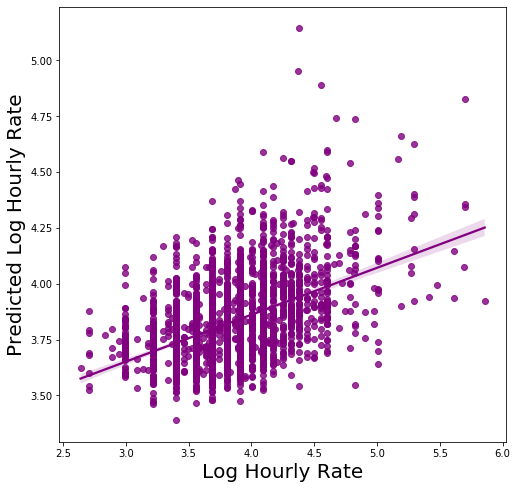

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))
b = sb.regplot(val_y,preds_val, color='purple')
b.set_xlabel("Log Hourly Rate",fontsize=20)
b.set_ylabel("Predicted Log Hourly Rate",fontsize=20)

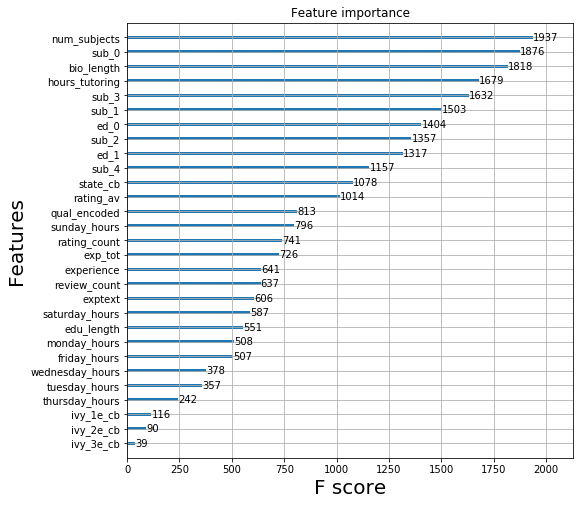

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))

c = plot_importance(model_xgb,ax=ax)
c.set_xlabel("F score",fontsize=20)
c.set_ylabel("Features",fontsize=20)
plt.show()

## Save all model weights for later use

In [ ]:
pickle.dump(model_xgb, open('weights/model_xgb3.sav', 'wb'))
pickle.dump(edPCA, open("weights/edPCA.pkl", "wb" ))
pickle.dump(subPCA, open("weights/subPCA.pkl", "wb" ))
pickle.dump(tfidf_sub, open("weights/tfidf.sav", "wb" ))
pickle.dump(tfidf_ed, open("weights/tfidf_ed.sav", "wb" ))
pickle.dump(cbenc, open("weights/cbenc2.pkl", "wb"))